<a href="https://colab.research.google.com/github/delpretemarcus/156StockClosingPricePrediction/blob/main/DataCleaningAndExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#Genuinely not sure which of these I use... Will trim as necessary
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [69]:

aplurl = 'https://raw.githubusercontent.com/delpretemarcus/156StockClosingPricePrediction/main/HistoricalQuotes.csv'

df = pd.read_csv(aplurl, index_col='Date')

In [120]:
#Data Cleaning --

df.columns = ['Close', 'Volume', 'Open', 'High', 'Low']
df.index = pd.to_datetime(df.index)
df.sort_index()

df.Close = df.Close.apply(lambda x: x[2:]).astype(np.double)
df.Open = df.Open.apply(lambda x: x[2:]).astype(np.double)
df.High = df.High.apply(lambda x: x[2:]).astype(np.double)
df.Low = df.Low.apply(lambda x: x[2:]).astype(np.double)


In [30]:
df.keys()

Index([' Close/Last', ' Volume', ' Open', ' High', ' Low'], dtype='object')

In [71]:
#Clean the data



In [108]:
#Scaling
features = ['Open', 'High', 'Low', 'Volume']
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2020-02-28,0.771523,0.834050,0.772861,0.211402
2020-02-27,0.852242,0.859527,0.829120,0.152499
2020-02-26,0.870627,0.899403,0.875036,0.084944
2020-02-25,0.919451,0.915011,0.873782,0.102656
2020-02-24,0.906957,0.920550,0.884294,0.097958


In [109]:
#Splitting to Training set and Test set
output_var = pd.DataFrame(df['Close'])
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
  X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
  y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()


In [110]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

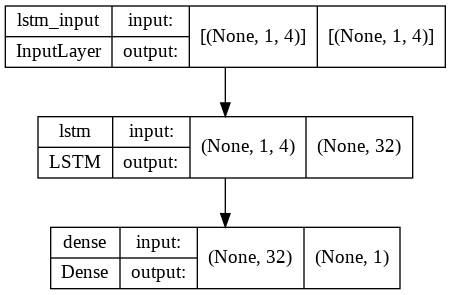

In [111]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [117]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, shuffle=False)


Epoch 1/100
144/144 [==============================] - 1s 4ms/step - loss: 2.5593
Epoch 2/100
144/144 [==============================] - 1s 5ms/step - loss: 2.5254
Epoch 3/100
144/144 [==============================] - 1s 5ms/step - loss: 2.5626
Epoch 4/100
144/144 [==============================] - 1s 4ms/step - loss: 2.5644
Epoch 5/100
144/144 [==============================] - 1s 4ms/step - loss: 2.5517
Epoch 6/100
144/144 [==============================] - 1s 4ms/step - loss: 2.5350
Epoch 7/100
144/144 [==============================] - 1s 4ms/step - loss: 2.5165
Epoch 8/100
144/144 [==============================] - 1s 4ms/step - loss: 2.4974
Epoch 9/100
144/144 [==============================] - 1s 4ms/step - loss: 2.4784
Epoch 10/100
144/144 [==============================] - 1s 4ms/step - loss: 2.4596
Epoch 11/100
144/144 [==============================] - 1s 4ms/step - loss: 2.4413
Epoch 12/100
144/144 [==============================] - 1s 4ms/step - loss: 2.4237
Epoch 13/100


In [118]:
y_pred = lstm.predict(X_test)

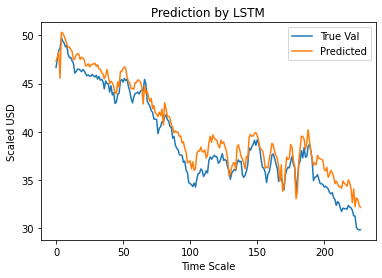

In [119]:
plt.plot(y_test, label='True Val')
plt.plot(y_pred, label='Predicted')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [120]:
#Maybe add Covid cases... / general covid sentiment. Seems to be quite poor indicator as covid begins